In [1]:
%matplotlib inline

In [2]:
import MDAnalysis as mda
import ARPDF, utils
import importlib
import matplotlib.pyplot as plt
import time

importlib.reload(ARPDF)
importlib.reload(utils)
from ARPDF import *
from ARPDF_POLAR import compute_ARPDF_polar
from utils import generate_grids

c:\Users\swz\anaconda3\envs\arpdf\Lib\site-packages\Bio\Application\__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [3]:
# u1 = mda.Universe('data/CCl4/CCl4.gro')
# u2 = mda.Universe('data/CCl4/CCl4_modified.gro')
# modified_atoms = [515, 516, 517, 518, 519, 645]
# polar_axis = [0.85692924,0.47545751,0.19902873]
# ori_range = 9.924650203173275
# X, Y, ARPDF_exp = utils.preprocess_ARPDF(np.load("data/CCl4/ARPDF_exp.npy"), ori_range, rmax=9.0)
X, Y, ARPDF_exp = utils.load_exp_data('data/CCl4', rmax=9.0)
ARPDF_exp = ARPDF_exp.T
u1, u2, modified_atoms, polar_axis = utils.load_structure_data('data/CCl4')
filter_fourier = lambda kX, kY, xp: (1 - xp.exp(-(kX**2 / 0.3 + kY**2 / 0.1)))**3 * xp.exp(-0.08 * (kX**2 + kY**2))

Using cupy to compute ARPDF...
Selected 461 atoms for universe 1, 477 atoms for universe 2.
Computing fields of universe 1...
Computed field for C-C: 118 atom pairs.
Computed field for C-CL: 679 atom pairs.
Computed field for CL-CL: 907 atom pairs.
Computing fields of universe 2...
Computed field for C-C: 118 atom pairs.
Computed field for C-CL: 674 atom pairs.
Computed field for CL-CL: 906 atom pairs.
Computing ARPDF...


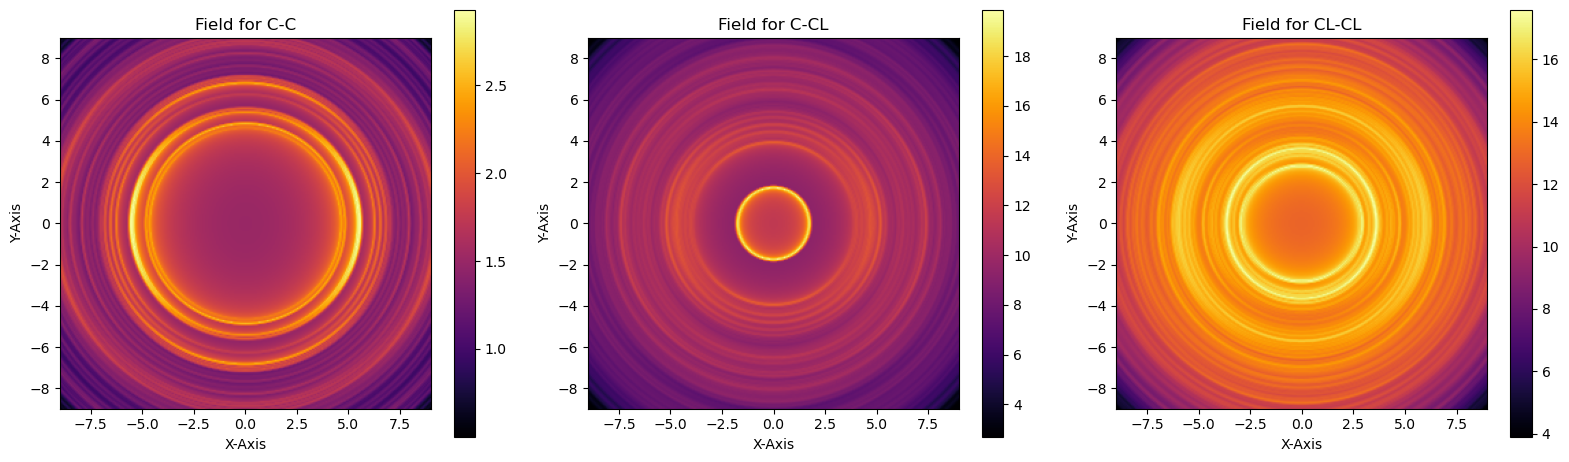

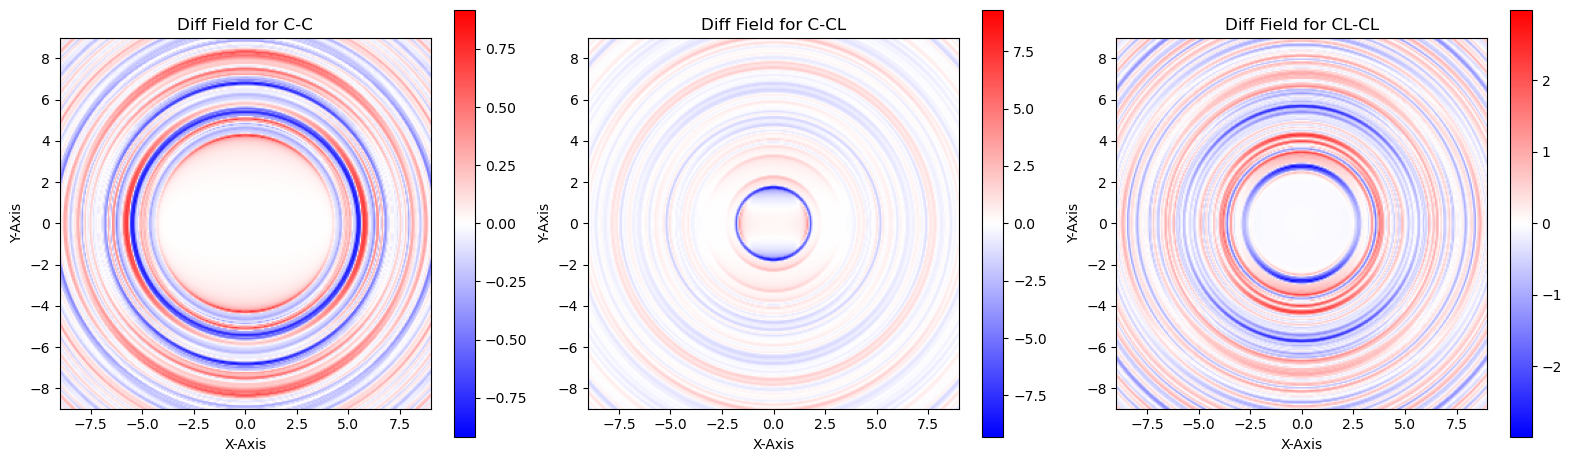

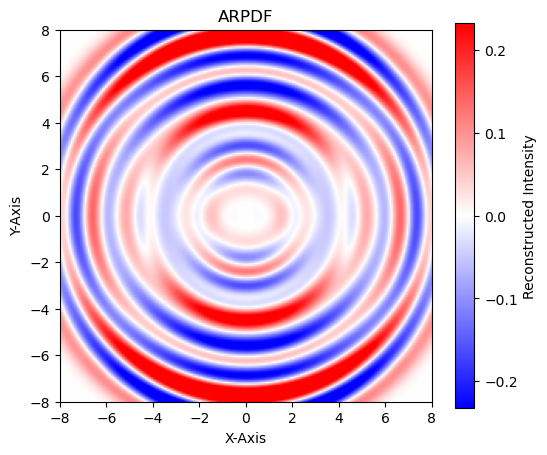

In [4]:
ARPDF = compute_ARPDF(u1, u2, cutoff=13.0, N=512, grids_XY=(X, Y), modified_atoms=modified_atoms, 
                        polar_axis=polar_axis, periodic=True, filter_fourier=filter_fourier, verbose=True)

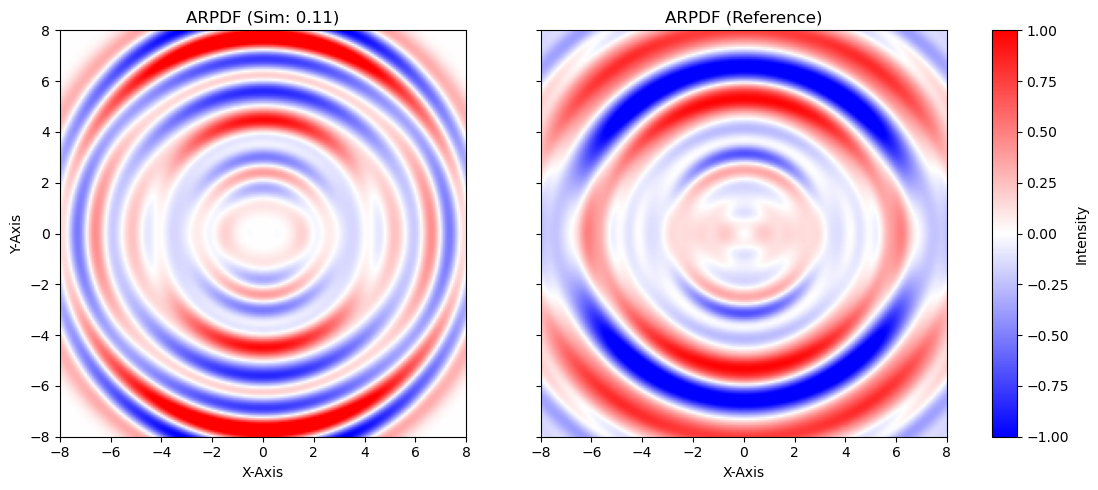

In [5]:
fig = compare_ARPDF(ARPDF, ARPDF_exp, (X, Y), show_range=8.0)
fig.savefig("tmp/ARPDF_example.png")

In [6]:
pos1 = u1.atoms[modified_atoms].positions
pos2 = u2.atoms[modified_atoms].positions
_u2 = u2.copy()
ARPDFs = []
for i, t in enumerate(np.linspace(0, 1, 20)):
    _u2.atoms[modified_atoms].positions = pos1 * (1 - t) + pos2 * t
    ARPDFs.append(compute_ARPDF(u1, _u2, cutoff=10.0, N=512, modified_atoms=modified_atoms, polar_axis=polar_axis, periodic=True, 
                                filter_fourier=filter_fourier, verbose=False))


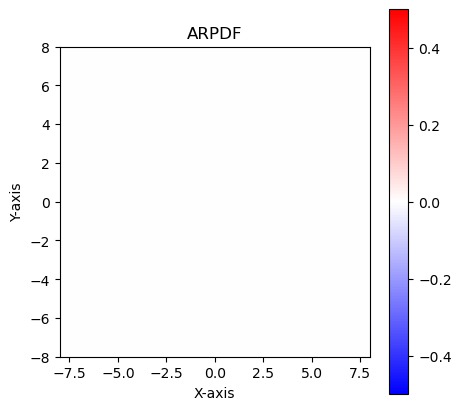

In [7]:
from matplotlib import pyplot as plt, animation
# 创建画布和初始图像
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(ARPDFs[0], origin="lower", cmap="bwr", extent=[-10, 10, -10, 10])
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_title("ARPDF")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
im.set_clim(-0.5, 0.5)
fig.colorbar(im, ax=ax)

In [8]:

# 更新函数：用于更新每一帧的图像
def update(frame):
    im.set_array(ARPDFs[frame])
    return [im]

# 创建动画 (frames 指定帧数, interval 控制帧间隔时间)
ani = animation.FuncAnimation(fig, update, frames=len(ARPDFs), interval=100, blit=True)

# 显示动画 (仅在 Jupyter Notebook 中运行)
from IPython.display import HTML
HTML(ani.to_jshtml())

In [9]:
ani.save("tmp/ARPDF.gif", writer="pillow", fps=10)

In [18]:
import ARPDF_POLAR
importlib.reload(ARPDF_POLAR)
from ARPDF_POLAR import compute_ARPDF_polar

Using cupy to compute ARPDF...
Selected 177 atoms in u1, 186 atoms in u2.
Computing polar fields for universe 1...
Computed polar field for C-C: 32 atom pairs.
Computed polar field for C-CL: 230 atom pairs.
Computed polar field for CL-CL: 295 atom pairs.
Computing polar fields for universe 2...
Computed polar field for C-C: 34 atom pairs.
Computed polar field for C-CL: 224 atom pairs.
Computed polar field for CL-CL: 300 atom pairs.


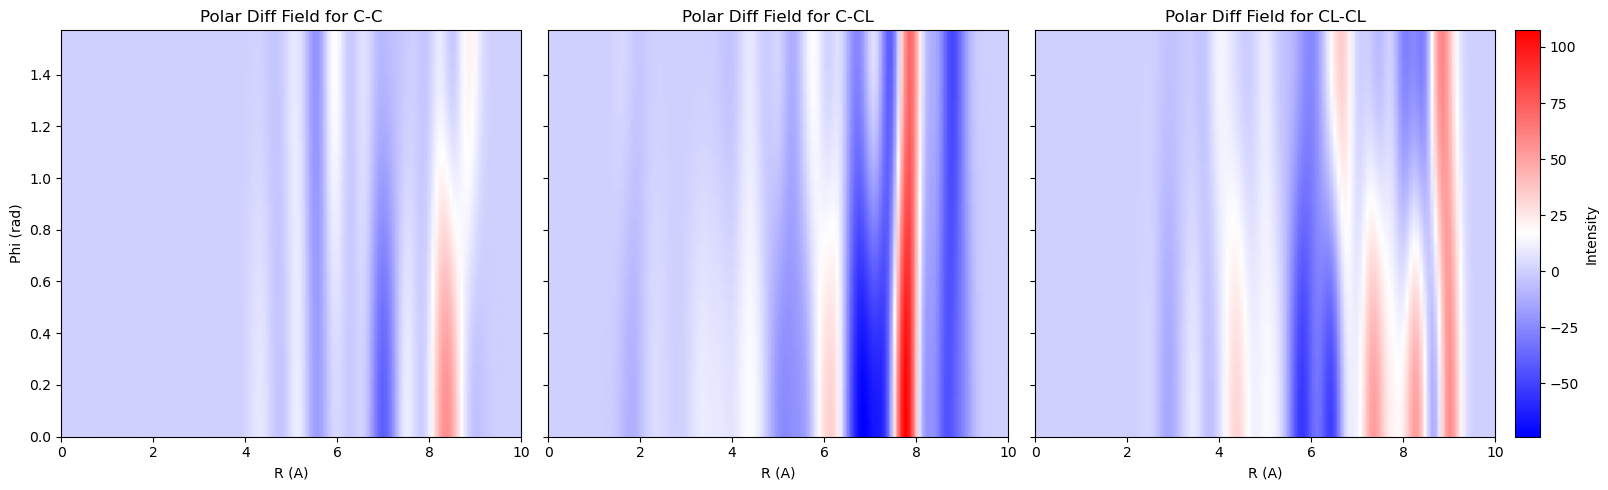

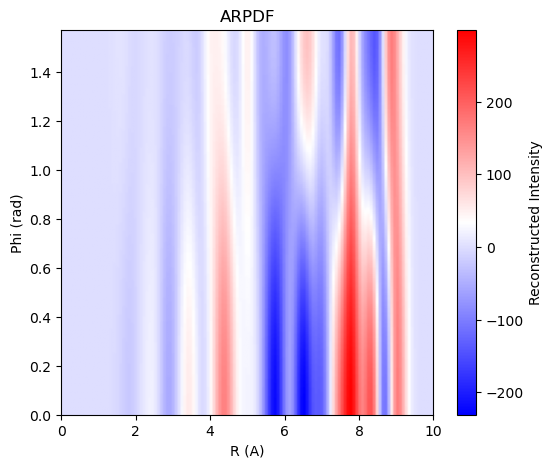

In [19]:
R, phi = generate_grids((0, 10, 0, 0.5*np.pi), 128, 180)
ARPDF_ref = compute_ARPDF_polar(u1, u2, N=512, cutoff=9.0, sigma0=0.2, grids_polar=(R, phi), modified_atoms=modified_atoms, 
                        polar_axis=polar_axis, periodic=True, verbose=True, neg=False)

In [13]:


X, Y = to_cupy(generate_grids(10, N=512))
n_repeat = 500
start_time = time.time()
for _ in range(n_repeat):
    _ = compute_ARPDF(u1, u2, cutoff=13.0, N=512, grids_XY=(X, Y), modified_atoms=modified_atoms, 
                      polar_axis=polar_axis, periodic=True, filter_fourier=filter_fourier, verbose=False)
end_time = time.time()

print(f"compute_ARPDF average calculation time: {(end_time - start_time)/n_repeat:.4f} seconds per run")

compute_ARPDF average calculation time: 0.0245 seconds per run


In [14]:
R, phi = to_cupy(generate_grids((0, 10, 0, 0.5*np.pi), 256, 100))
n_repeat = 500
start_time = time.time()
for _ in range(n_repeat):
    _ = compute_ARPDF_polar(u1, u2, N=512, cutoff=9.0, sigma0=0.2, grids_polar=(R, phi), modified_atoms=modified_atoms, 
                        polar_axis=polar_axis, periodic=True, verbose=False, neg=False)
end_time = time.time()

print(f"compute_ARPDF_polar average calculation time: {(end_time - start_time)/n_repeat:.4f} seconds per run")

compute_ARPDF_polar average calculation time: 0.0158 seconds per run
